In [3]:
import os 
import copy 
import numpy as np
np.set_printoptions(suppress=True, precision=3)

from scipy.spatial.transform import Rotation as R

import open3d as o3d

import symforce 
# symforce.set_log_level("warning")
symforce.set_log_level("ERROR")
print(f"symforce uses {symforce.get_symbolic_api()} as backend")

from symforce.notebook_util import display
import symforce.symbolic as sf
from symforce.values import Values
from symforce import ops
from symforce.ops import StorageOps, GroupOps, LieGroupOps

from symforce.opt.factor import Factor
from symforce.opt.optimizer import Optimizer
from symforce.values import Values

from symforce import typing as sfT

symforce uses symengine as backend


In [4]:
from time import time
  
# ref: https://www.geeksforgeeks.org/timing-functions-with-decorators-python/
disp_timecost = True 
def timer(func):
    # This function shows the execution time of 
    # the function object passed
    def wrap_func(*args, **kwargs):
        t1 = time()
        result = func(*args, **kwargs)
        t2 = time()
        
        if disp_timecost:
            print(f'Function {func.__name__} executed in {(t2-t1):.4f}s')

        return result
    return wrap_func


In [5]:
### generate a mini graph having 4 poses

# helper funcs 
def move(prev_pose, x_meter=1.0, yaw_deg=90):
    # input: assume prev_pose is 4x4 SE(3) matrix 
    # output: SE(3), the moved (transformed) pose 

    def rpy2mat(rpy, deg=True):
        return R.from_euler('xyz', rpy, degrees=deg).as_matrix()

    def movement():
        movement_yaw = yaw_deg # deg, means turn left
        movement_SO3 = rpy2mat(np.array([0, 0, movement_yaw]))

        movement_trans = [x_meter, 0.0, 0.0] # x means moving direction (forward)

        movement = np.eye(4) # SE(3)
        movement[:3, :3] = movement_SO3
        movement[:3, -1] = movement_trans
        
        return movement 
    
    tf = movement()
    next_pose = prev_pose @ tf

    return next_pose, tf

# initial pose 
pose_start = np.eye(4)

# evolv poses 
curr_pose = pose_start
poses_gt = [curr_pose] # poses to be appended to this list 

num_poses = 8 + 1
n = (num_poses-1)
yaw_onestep = 180 * (n-2) / n

odoms_gt = []
for ii in range(num_poses-1):
    moved_pose, odom = move(curr_pose, x_meter=3.0, yaw_deg=yaw_onestep)
    poses_gt.append(moved_pose)
    odoms_gt.append(odom)
    
    curr_pose = moved_pose

# generate loop factor (between the start and the end poses)
loops_gt = [] 
# loops_indexes = [(num_poses-1, 0), (1, 4), (2, 4), (0, 3)]
loops_indexes = [(num_poses-1, 0)]
for loops_index_pair in loops_indexes:
    idx_from = loops_index_pair[0]
    idx_to = loops_index_pair[1]
    loop_gt = np.linalg.inv(poses_gt[idx_from]) @ poses_gt[idx_to]
    loops_gt.append(loop_gt)

# debug 
_ = [print(f"The generated GT pose of idx {i} is:\n {pose}") for i, pose in enumerate(poses_gt)]    

print("")
_ = [print(f"The applied GT control input between idx {i} and {i+1} is:\n {odom}") \
     for i, odom in enumerate(odoms_gt)]    

print("")
_ = [print(f"The GT loop closure factors between idx {idx[0]} and {idx[1]} is:\n {loop}") \
     for _, (idx, loop) in enumerate(zip(loops_indexes, loops_gt))]   

The generated GT pose of idx 0 is:
 [[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]
The generated GT pose of idx 1 is:
 [[-0.707 -0.707  0.     3.   ]
 [ 0.707 -0.707  0.     0.   ]
 [ 0.     0.     1.     0.   ]
 [ 0.     0.     0.     1.   ]]
The generated GT pose of idx 2 is:
 [[-0.     1.     0.     0.879]
 [-1.    -0.     0.     2.121]
 [ 0.     0.     1.     0.   ]
 [ 0.     0.     0.     1.   ]]
The generated GT pose of idx 3 is:
 [[ 0.707 -0.707  0.     0.879]
 [ 0.707  0.707  0.    -0.879]
 [ 0.     0.     1.     0.   ]
 [ 0.     0.     0.     1.   ]]
The generated GT pose of idx 4 is:
 [[-1.    -0.     0.     3.   ]
 [ 0.    -1.     0.     1.243]
 [ 0.     0.     1.     0.   ]
 [ 0.     0.     0.     1.   ]]
The generated GT pose of idx 5 is:
 [[ 0.707  0.707  0.     0.   ]
 [-0.707  0.707  0.     1.243]
 [ 0.     0.     1.     0.   ]
 [ 0.     0.     0.     1.   ]]
The generated GT pose of idx 6 is:
 [[ 0.    -1.     0.     2.121]
 [ 1.     0.     0.    -0.879]


In [6]:
# error models (cost functions)
eps = 0.000001

def prior_residual(
        pose    : sf.Pose3, 
        pose_prior: sf.Pose3,
        diagonal_sigmas: sf.V6 
    ) -> sf.V6:

    tangent_error = pose.local_coordinates(pose_prior, epsilon=eps)
    return sfT.cast(sf.V6, sf.M.diag(diagonal_sigmas.to_flat_list()).inv() * sf.V6(tangent_error))

def odometry_residual(
        pose_prev: sf.Pose3, 
        pose_next: sf.Pose3, 
        movement : sf.Pose3,
        diagonal_sigmas: sf.V6,
    ) -> sf.V6:
    
    # The original reference of the below lines 
    #  - see https://github.com/symforce-org/symforce/blob/main/symforce/examples/robot_3d_localization/robot_3d_localization.py#L63
    movement_predicted = pose_prev.inverse() * pose_next
    tangent_error = movement_predicted.local_coordinates(movement, epsilon=eps)
    return sfT.cast(sf.V6, sf.M.diag(diagonal_sigmas.to_flat_list()).inv() * sf.V6(tangent_error))

def loop_residual(
        pose_prev: sf.Pose3, 
        pose_next: sf.Pose3, 
        movement : sf.Pose3,
        diagonal_sigmas: sf.V6,
    ) -> sf.V6:

    return odometry_residual(pose_prev, pose_next, movement, diagonal_sigmas)
    

In [56]:
## generate factors
def np2sf_batch(mats_np, use_trans_noise=False):

    def SE3_np2sf(mat: np.ndarray, use_trans_noise=False):
        mat_sf = sf.Pose3.identity()
        mat_sf.t = sf.V3(mat[:3, -1])
        mat_sf.R = sf.Rot3.from_rotation_matrix(mat[:3, :3], epsilon=sf.numeric_epsilon)

        perturb_alpha = 1.0
        if not use_trans_noise:
            perturb_alpha = 0.0 

        perturb = perturb_alpha * np.array([0.005, 0.005, 0.005, 0.2, 0.2, 0.002])
        tangent_perturbation = np.random.normal(size=6) * perturb
        return mat_sf.retract(tangent_perturbation, epsilon=sf.numeric_epsilon)

    mats_sf = []
    for mat in mats_np:
        mats_sf.append(SE3_np2sf(mat, use_trans_noise=use_trans_noise))    
        
    return mats_sf

poses_prior = np2sf_batch(poses_gt, use_trans_noise=False)
odoms_obs   = np2sf_batch(odoms_gt, use_trans_noise=True)
loops_obs   = np2sf_batch(loops_gt, use_trans_noise=False)

## noises 
prior_diagonal_sigmas = np.array([0.001, 0.001, 0.001, 0.01, 0.01, 0.01]) * 0.001
odometry_diagonal_sigmas = np.array([0.05, 0.05, 0.05, 0.1, 0.1, 0.1]) 
loop_diagonal_sigmas = odometry_diagonal_sigmas * 0.1

## initial values (note that using identity cannot converges, thus perturb the prior value and use it.)
initial_poses = []
for ii, pose_prior in enumerate(poses_prior):
    tangent_perturbation = np.random.normal(size=6) * 5*np.array([0.05, 0.05, 0.05, 0.2, 0.2, 0.2])
    initial_pose = pose_prior.retract(tangent_perturbation)
    initial_poses.append(initial_pose)
    
    trans_init_guess = np.array(initial_pose.t.transpose()).astype('float')
    trans_gt = np.array(pose_prior.t.transpose()).astype('float')
    print(f"initial location at {ii} is {trans_init_guess} (true is: {trans_gt})")

initial_values = Values(
    # poses=[sf.Pose3.identity()] * num_poses, # may not converge.
    poses=initial_poses,
    
    poses_prior=poses_prior,
    prior_diagonal_sigmas=prior_diagonal_sigmas,

    odoms=odoms_obs,
    odometry_diagonal_sigmas=odometry_diagonal_sigmas,
    
    loops=loops_obs,
    loop_diagonal_sigmas=loop_diagonal_sigmas,
)

initial location at 0 is [-0.794  0.864  1.023] (true is: [0. 0. 0.])
initial location at 1 is [ 1.525 -0.159  1.232] (true is: [3. 0. 0.])
initial location at 2 is [-0.204  1.341  0.977] (true is: [0.879 2.121 0.   ])
initial location at 3 is [ 1.47  -0.437  0.763] (true is: [ 0.879 -0.879  0.   ])
initial location at 4 is [1.544 1.531 0.552] (true is: [3.    1.243 0.   ])
initial location at 5 is [ 1.579  1.732 -0.354] (true is: [0.    1.243 0.   ])
initial location at 6 is [ 2.153 -0.593 -0.259] (true is: [ 2.121 -0.879  0.   ])
initial location at 7 is [ 2.217  0.898 -0.111] (true is: [2.121 2.121 0.   ])
initial location at 8 is [-0.878 -0.315 -1.125] (true is: [-0.  0.  0.])


In [59]:

use_factors = {
    'prior': True,
    'odometry': True,
    'loop': True, # test True or False
}

factors = []

# 1/ Prior factors 
if use_factors['prior']:
    for i in range(num_poses):
        if i not in [0]:
#         if i not in [0,1,2,3,4,5,6,7]:
            continue 
        
        # only add at the first node 
        factors.append(Factor(
            residual=prior_residual,
            keys=[f"poses[{i}]", f"poses_prior[{i}]", f"prior_diagonal_sigmas"],
        ))

# 2/ Odometry factors
if use_factors['odometry']:        
    for i in range(num_poses-1):        
        factors.append(Factor(
            residual=odometry_residual,
            keys=[f"poses[{i}]", f"poses[{i+1}]", f"odoms[{i}]", "odometry_diagonal_sigmas"],
        ))

# 3/ Loop factors
if use_factors['loop']:
    for ii, loops_index_pair in enumerate(loops_indexes):        
        idx_from = loops_index_pair[0]
        idx_to = loops_index_pair[1]
        factors.append(Factor(
            residual=odometry_residual,
            keys=[f"poses[{idx_from}]", f"poses[{idx_to}]", f"loops[{ii}]", "loop_diagonal_sigmas"],
        ))

## do opt 
optimizer = Optimizer(
    factors=factors,
    optimized_keys=[f"poses[{i}]" for i in range(num_poses)],
    debug_stats=True,
)

# result vis 
result = optimizer.optimize(initial_values)
poses_opt = result.optimized_values['poses']
print("\nThe optimized poses are:")
for ii, pose_opt in enumerate(poses_opt):
    pose7 = pose_opt.data
    q = np.array(pose7[:4])
    ypr = np.rad2deg(np.array(pose_opt.rotation().to_yaw_pitch_roll()))
    rpy = np.array([ypr[-1], ypr[1], ypr[0]])
    t = np.array(pose7[4:])
    print(f"t at {ii}: {t}, rpy (deg): {rpy}") 


The optimized poses are:
t at 0: [ 0. -0. -0.], rpy (deg): [0. 0. 0.]
t at 1: [ 2.691 -0.089 -0.003], rpy (deg): [  0.043  -0.088 135.456]
t at 2: [0.754 2.102 0.004], rpy (deg): [ -0.25   -0.281 -91.281]
t at 3: [ 0.778 -1.145  0.018], rpy (deg): [ 0.179  0.365 45.378]
t at 4: [2.841 0.88  0.   ], rpy (deg): [  -0.14    -0.282 -179.784]
t at 5: [-0.094  1.198  0.017], rpy (deg): [  0.1     0.207 -45.082]
t at 6: [ 2.094 -1.037  0.002], rpy (deg): [ 0.076 -0.195 91.385]
t at 7: [2.262 2.135 0.015], rpy (deg): [  -0.083    0.29  -135.225]
t at 8: [ 0.001 -0.    -0.   ], rpy (deg): [ 0.001  0.001 -0.004]


<IPython.core.display.Javascript object>


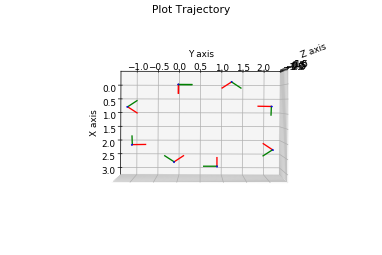

In [60]:
### draw the result 
# %matplotlib inline
%matplotlib notebook 
import matplotlib.pyplot as plt

import gtsam
from gtsam.utils import plot

# gather data 
def pose(R, t):
    return gtsam.Pose3(R, t)

result = gtsam.Values()
for ii, pose_opt in enumerate(poses_opt):
    pose7 = pose_opt.data
    t = np.array(pose7[4:])
    q = np.array(pose7[:4])
    SE3 = np.eye(4)
    SE3[:3, :3] = R.from_quat(q).as_matrix()
    SE3[:3, -1] = t
    result.insert(ii, gtsam.Pose3(SE3))

# draw
fig_idx = 1
plot.plot_trajectory(fig_idx, result, scale=0.3)
plot.set_axes_equal(True)
plt.show()
